In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from pyedflib import highlevel
from sklearn.decomposition import PCA, FastICA
import numpy as np
import os
import mne
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from srcs.preprocessing import retrieve_data, parse_filter_data
PATH='/mnt/nfs/homes/thoberth/sgoinfre/physionet.org/files/eegmmidb/1.0.0/'

In [2]:
data = retrieve_data(PATH)

  0%|          | 0/40 [00:00<?, ?it/s]

# Separate both type of labels and standardize value

In [3]:
# Must optimize this part of preprocessing
X, y = parse_filter_data(data.copy(), 'mne')
X.shape, y.shape

mne normalisation ...
<class 'numpy.ndarray'> (64, 8286720)


((6289, 64, 113), (6289,))

## Reshape les données pour les rendre en 2D

In [4]:
# (n_epochs, n_channels * n_times)
X = X.reshape(X.shape[0], -1)
X.shape

(1620, 7232)

# Show explained variance for each number of component

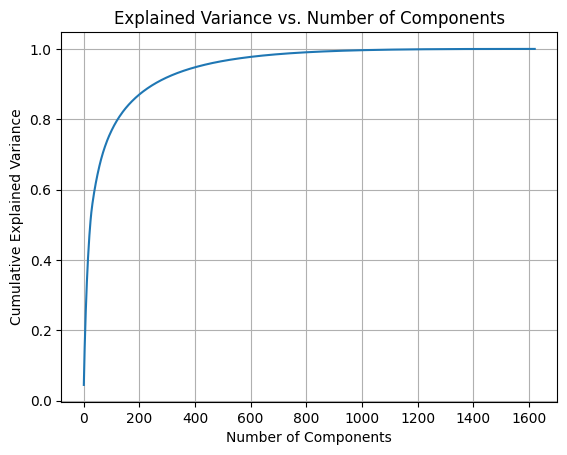

In [5]:
pca = PCA().fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

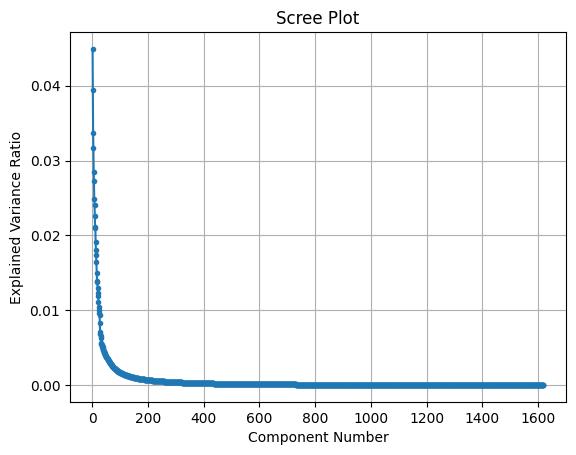

In [6]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-', markersize=3)
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)

plt.show()

# Define the n components after analysis

In [7]:
n_components = 250

# Dimension Reduction using PCA

In [6]:
XReducted = PCA(n_components=n_components).fit_transform(X)

NameError: name 'n_components' is not defined

# Dimension reduction using CSP

In [5]:
from mne.decoding import CSP
XReducted = CSP(n_components=10).fit_transform(X, y)
XReducted.shape

Computing rank from data with rank=None
    Using tolerance 0.0009 (2.2e-16 eps * 64 dim * 6.4e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.


(6289, 10)

# Classification Algo

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
X_train, X_test, y_train, y_test = train_test_split(XReducted, y, test_size=0.15, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5345, 10) (5345,) (944, 10) (944,)


# RandomForestClassifier

In [15]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Score de precisions :", accuracy_score(y_test, y_pred))

Score de precisions : 0.6101694915254238


# LogisticRegression

In [13]:
classifier = LogisticRegression(random_state=42, verbose=False)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Score de precisions :", accuracy_score(y_test, y_pred))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  5.59056D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   5.465D-05   6.676D-01
  F =  0.66761845260792063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Score de precisions : 0.6165254237288136


 This problem is unconstrained.


# SVC

In [8]:
classifier = SVC(random_state=42, verbose=False)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Score de precisions :", accuracy_score(y_test, y_pred))

Score de precisions : 0.6154661016949152


# Now lets create a real pipeline for training